# Gaussian Mixture Model Exoplanet Atmospheric Retrieval 

In [5]:
#%pip install umap-learn --break-system-packages

### Import delle librerie e file ARIEL

In [6]:
import numpy as np
import pandas as pd
import os
import h5py
import random
import sys
import corner
import matplotlib.pyplot as plt
import taurex.log
import importlib
import seaborn as sns
import posterior_utils
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Importa dinamicamente il modulo helper
import helper
importlib.reload(helper) 
check_parameters_valid = helper.check_parameters_valid
# Aggiungi il percorso della directory contenente helper.py
sys.path.append(os.path.abspath('./'))
importlib.reload(posterior_utils)

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
from submit_format import *
from matplotlib.lines import Line2D
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from helper import *
from preprocessing import *
from submit_format import to_competition_format
from posterior_utils import *
from spectral_metric import *
from FM_utils_final import *
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from submit_format import get_unique_filename
from sklearn.exceptions import ConvergenceWarning

taurex.log.disableLogging()
np.set_printoptions(suppress=True, linewidth=np.nan, threshold=sys.maxsize)
# Filtering dei Warning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="more than 1 Rp value detected in the trace! Using first value")

/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting variabili
### Utilizziamo lo StandardScaler per trasformare e scalare gli input ottenendo *media unitaria* e *varianza nulla*

In [7]:
n_repeat = 5
random_state = 420
# random_state = random.randint(1,1000)
# print(f'Random State : {random_state}')

# Lettura dati dai file 
aux = np.load('aux.npy')
spec_matrix = np.load('spectra.npy')
noise = np.load('noise.npy')
labels = np.load('label.npy')
validTraces = np.load('validTraces.npy')
num_spectra = spec_matrix.shape[0]
labels_names = ['planet_radius','planet_temp','log_H2O','log_CO2','log_CO','log_CH4','log_NH3']

# Setting dei path
training_path = './Check_Dataset/TrainingData'
training_GT_path = os.path.join(training_path, 'Ground Truth Package')
trace_GT = h5py.File(os.path.join(training_GT_path, 'TraceData.hdf5'), "r")
validTraces = validTraces.astype(np.int64)
for X in trace_GT.keys():
    tr_GT = trace_GT[X]['tracedata'][()]
    weights_GT = trace_GT[X]['weights'][()]
    if np.isnan(tr_GT).sum() == 1:
        continue
    validTraces = np.append(validTraces, int(X[12:]))
vt = validTraces
# print(f'vt.size : {vt.size}')
test_ind = np.sort(vt - 1)
train_ind = np.setdiff1d(np.arange(num_spectra), test_ind)
plot_ind = random.sample(range(len(test_ind)), 10)
spectra_ind = random.sample(range(len(test_ind)), 10)

#-------|Preprocessing dei dati spettrali|--------

# Preprocessamento dei test spectra
test_spectra = spec_matrix[test_ind, :]
test_spectra = augment_data(test_spectra, noise[test_ind, :], repeat=1)
test_spectra = test_spectra.reshape(-1, spec_matrix.shape[1])

# Preprocessamento dei train spectra
train_spectra = spec_matrix[train_ind, :]
train_spectra = augment_data(train_spectra, noise[train_ind, :], repeat=n_repeat)
train_spectra = train_spectra.reshape(-1, spec_matrix.shape[1])

# Dati ausiliari e labels
train_aux = aux[train_ind, :]
train_aux = np.repeat(train_aux, repeats=n_repeat, axis=0)
test_aux = aux[test_ind, :]
train_labels = labels[train_ind, :]
train_labels = np.repeat(train_labels, repeats=n_repeat, axis=0)
test_labels = labels[test_ind, :]

# Applichiamo StandardScaler per preservare meglio la distribuzione originale
scaler = StandardScaler()
train_spectra = scaler.fit_transform(train_spectra)
test_spectra = scaler.transform(test_spectra)

# print(f'train_spectra.size : {train_spectra.shape} - test_spectra.size : {test_spectra.shape}')

# Setup per gli score

In [8]:
# Liste per salvare tutti gli score
posterior_scores = []
spectral_scores = []
# Inizializziamo la bounds_matrix, ovvero la matrice delle distrubuzioni a priori delle molecole
bounds_matrix = default_prior_bounds()
beta = 0.8
q_list = np.linspace(0.01, 0.99, 10) # Lista di q per il calcolo del quantile
opacity_path = "./XSEC/"
CIA_path = "./HITRAN"
# Carichiamo i dati dello strumento simulato di ARIEL
ariel_wlgrid, ariel_wlwidth, ariel_wngrid, ariel_wnwidth = ariel_resolution()
# Inizializziamo il forward model (modello planetario)
fm = initialise_forward_model(opacity_path, CIA_path)
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
Rs = aux[:, 2] / RSOL
Mp = aux[:, 4] / MJUP
n_samples = 1000

# Applicazione del Clustering
- $K_1$ : numero di cluster di 1o livello
- $K_2$ : numero di 'sottocluster' (cluster di 2o livello)
- $GMM_i$ : output del Gaussian Mixture Model
- $Labels_i$ : labels ottenute dal GMM di ciascun livello
> Cerchiamo, in ogni sottocluster (K2), i cluster contenenti un singolo spettro, che sono considerati *outlier*, cioe' anomali (composti da un solo spettro)

`Si puo' usare il BIC (o l'AIC) per ottenere i migliori valori di $K_1$ e $K_2$`

In [9]:
# (19,15) risulta essere la migliore coppia
'''
n_components_range = range(10, 25) # TODO : Testare valori differenti del range
bic_scores = []
aic_scores = []
for n in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n,random_state=random_state,max_iter=500).fit(train_aux)
    bic_scores.append(gmm_tmp.bic(train_aux))
    aic_scores.append(gmm_tmp.aic(train_aux))
# Trova il numero di componenti con il minimo BIC e AIC
best_n_components_bic = n_components_range[np.argmin(bic_scores)]
best_n_components_aic = n_components_range[np.argmin(aic_scores)]
K1_b = best_n_components_bic
K2_a = best_n_components_aic
print(f'K1 = {K1_b}, K2 = {K2_a}')
'''
K1 = 19
K2 = 15
GMM_i = []
Labels_i = []
# Primo clustering (1° livello) sui dati ausiliari
gmm = mixture.GaussianMixture(n_components=K1, random_state=random_state, max_iter=400).fit(train_aux)
labels_1 = gmm.predict(train_aux)
for i in range(K1):
    spectra_i = np.where(labels_1 == i)[0]
    print("Spettri nel cluster #", i, " -> ", len(spectra_i))
    # Secondo clustering (2° livello) sui dati spettrali appartenenti al cluster i
    tmp = mixture.GaussianMixture(n_components=K2, random_state=random_state).fit(train_spectra[spectra_i, :])
    labels_2 = tmp.predict(train_spectra[spectra_i, :])
    GMM_i.append(tmp)
    Labels_i.append(labels_2)
    for j in range(K2):
        spectra_j = np.where(labels_2 == j)[0]
        if len(spectra_j) == 1:
            print(f"\t [{i}].{j} sottocluster con singolo spettro [OUTLIER]")
            spectra_i = np.delete(spectra_i,spectra_j) # Rimozione dell'outlier

Spettri nel cluster # 0  ->  18300
Spettri nel cluster # 1  ->  3430
Spettri nel cluster # 2  ->  16260
Spettri nel cluster # 3  ->  330
	 [3].10 sottocluster con singolo spettro [OUTLIER]
Spettri nel cluster # 4  ->  3430
Spettri nel cluster # 5  ->  12250
Spettri nel cluster # 6  ->  18815
Spettri nel cluster # 7  ->  22470
Spettri nel cluster # 8  ->  7695
Spettri nel cluster # 9  ->  14845
Spettri nel cluster # 10  ->  2135
Spettri nel cluster # 11  ->  5390
Spettri nel cluster # 12  ->  385
	 [12].3 sottocluster con singolo spettro [OUTLIER]
Spettri nel cluster # 13  ->  6470
Spettri nel cluster # 14  ->  24660
Spettri nel cluster # 15  ->  770
Spettri nel cluster # 16  ->  4480
Spettri nel cluster # 17  ->  9605
Spettri nel cluster # 18  ->  1565


## Calcolo degli score

In [10]:
# Liste per salvare tutti gli score
posterior_scores = []
spectral_scores = []
# Inizializziamo la bounds_matrix, ovvero la matrice delle distrubuzioni a priori delle molecole
bounds_matrix = default_prior_bounds()
beta = 0.8
q_list = np.linspace(0.01, 0.99, 10) # Lista di q per il calcolo del quantile
opacity_path = "./XSEC/"
CIA_path = "./HITRAN"
# Carichiamo i dati dello strumento simulato di ARIEL
ariel_wlgrid, ariel_wlwidth, ariel_wngrid, ariel_wnwidth = ariel_resolution()
# Inizializziamo il forward model (modello planetario)
fm = initialise_forward_model(opacity_path, CIA_path)
RJUP = 69911000
MJUP = 1.898e27
RSOL = 696340000
Rs = aux[:, 2] / RSOL
Mp = aux[:, 4] / MJUP
n_samples = 1000
# Calcoliamo lo score solo su una parte dei sample (fino a 2*spec_max)
spec_max = 40
n_spec = 0
spec_ind = random.sample(range(len(test_ind)),spec_max*2)
# Liste per salvare i parametri usati e gli score ottenuti
'''
k1_vals = []
k2_vals = []
posterior_scores_k = []
spectral_scores_k = []
scores_k = []
'''
for X in range(len(test_ind)):
	# Fitting sui dati ausiliari
	idx1 = gmm.predict(test_aux[X, :].reshape(1, -1))[0]
	km = GMM_i[idx1] 
	labels_2 = Labels_i[idx1]
	# Fitting sui dati spettrali
	idx2 = km.predict(test_spectra[X, :].reshape(1, -1))[0]
	idx_1 = np.where(labels_1 == idx1)[0]
	idx_2 = np.where(labels_2 == idx2)[0]
	cluster_membs = idx_1[labels_2==idx2] # Indici dei membri del cluster
	# Estraiamo i membri del cluster
	lab = train_labels[cluster_membs,:]
	lab = lab.reshape(-1,lab.shape[-1])
	posterior = lab

	# Calcoliamo il peso di ogni membro del cluster
	weights1 = np.ones((posterior.shape[0],1)) / posterior.shape[0]
	planet_index = test_ind[X]+1
	# Carichiamo i dati del ground truth
	tr_GT = trace_GT[f'Planet_train{planet_index}']['tracedata'][()]
	wh_GT = trace_GT[f'Planet_train{planet_index}']['weights'][()]
	# Controllo se ci sono nan -> se ci sono, non calcoliamo lo score
	if np.isnan(tr_GT).sum() >= 1:
		print("nan trovato")
		exit()
	score = compute_posterior_loss(posterior, weights1, tr_GT, wh_GT,bounds_matrix)
	posterior_scores.append(score)
	if n_spec<spec_max and X in spec_ind:
		try:
			proxy_compute_spectrum = setup_dedicated_fm(fm, test_ind[X], Rs, Mp, ariel_wngrid, ariel_wnwidth )
			sscore = compute_spectral_loss(posterior, weights1, tr_GT, wh_GT, bounds_matrix, proxy_compute_spectrum, q_list)
			spectral_scores.append(sscore)
			print('*****Spectral: ',sscore)
			print('*****Posterior: ',score)
			n_spec+=1
		except RuntimeWarning:
			continue

/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  805.0307892007795
*****Posterior:  453.15549117830494


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  960.8696501578846
*****Posterior:  430.0667126754083


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  771.427026292349
*****Posterior:  412.3989218328841


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  735.3942101738317
*****Posterior:  341.19278779472955


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  788.8495214679524
*****Posterior:  372.1443483447659


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  788.8495214679524
*****Posterior:  370.1759618252312


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  669.6636448626587
*****Posterior:  394.1660433807031


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  681.9242539182737
*****Posterior:  503.5074688454238


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  784.5472474584578
*****Posterior:  359.0397412774426


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  909.6508823333428
*****Posterior:  397.75175644028104


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  671.1942527508722
*****Posterior:  385.4020884917644


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  729.0565928404905
*****Posterior:  349.61439588688944


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  820.2601189045336
*****Posterior:  322.906981068918


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  725.5278277740756
*****Posterior:  363.8742210170781


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  726.0046962230817
*****Posterior:  512.4962719952282


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  846.4348187932799
*****Posterior:  414.2290422424691


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  676.7718958556469
*****Posterior:  377.23029658513536


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  730.2838991132235
*****Posterior:  335.5616916145909


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  739.2591334519522
*****Posterior:  354.0100250626566


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  730.6078700995741
*****Posterior:  313.6415036151184


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  592.4969233168035
*****Posterior:  436.9290573372206


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  703.7469279523567
*****Posterior:  367.901972504483


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  950.0945875960514
*****Posterior:  419.2037470725995


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  746.1546973175446
*****Posterior:  352.078239608802


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  972.734225332759
*****Posterior:  444.30913348946126


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  668.6725688807494
*****Posterior:  344.85407066052227


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  684.5742092734577
*****Posterior:  458.03416687298835


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  816.656863396115
*****Posterior:  496.0084033613445


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  583.1554146663614
*****Posterior:  421.0919970082274


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  830.4512807173046
*****Posterior:  274.4162991829898


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  689.4515975387314
*****Posterior:  451.05710985928766


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  679.8620747159114
*****Posterior:  358.1453634085212


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  678.8747446018517
*****Posterior:  463.3437399074173


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  841.1095524683776
*****Posterior:  430.1989334030836


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  672.9803809119624
*****Posterior:  311.14508060033353


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  712.8906151311323
*****Posterior:  368.6635944700461


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  844.947924348916
*****Posterior:  450.72439353099736


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  769.0996926445396
*****Posterior:  335.7002709520695


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  473.74465317468025
*****Posterior:  396.66934189406095


/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:109: RuntimeWarning: invalid value encountered in sqrt
  k[0] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:113: RuntimeWarning: invalid value encountered in sqrt
  k[1:] = np.sqrt(
/Users/eugeniomiliterno/Library/Python/3.12/lib/python/site-packages/taurex/model/transmission.py:118: RuntimeWarning: invalid value encountered in sqrt
  k[1:] -= np.sqrt(


*****Spectral:  530.9619811615701
*****Posterior:  352.5334095619238


# Calcolo degli score medi
- Posterior Score : 80%
- Spectral Score : 20%
- Final score = Score finale per la Leaderboard
> final_score = 0.8 * posterior_score + 0.2 * spectral_score

In [ ]:
avg_posterior_score = np.mean(posterior_scores)
print(f'Posterior_Score: {avg_posterior_score}')
avg_spectral_score = np.mean(spectral_scores)
print(f'Spectral_Score: {avg_spectral_score}')
final_score = (1 - beta) * avg_spectral_score + beta * avg_posterior_score
print(f"final score: {final_score:.4f}")    
# Salvataggio risultati
'''
k1_vals.append(K1)
k2_vals.append(K2)
posterior_scores_k.append(avg_posterior_score)
spectral_scores_k.append(avg_spectral_score)
scores_k.append(final_score)
with open("results.txt", "a") as f:
    f.write("\n------------------------------\n")
    f.write("K1: {}\n".format(k1_vals))
    f.write("K2: {}\n".format(k2_vals))
    f.write("Posterior scores: {}\n".format(posterior_scores_k))
    f.write("Spectral scores: {}\n".format(spectral_scores_k))
    f.write("Final scores: {}\n".format(scores_k))
f.close()
'''

## Plotting grafico Score/Clustering

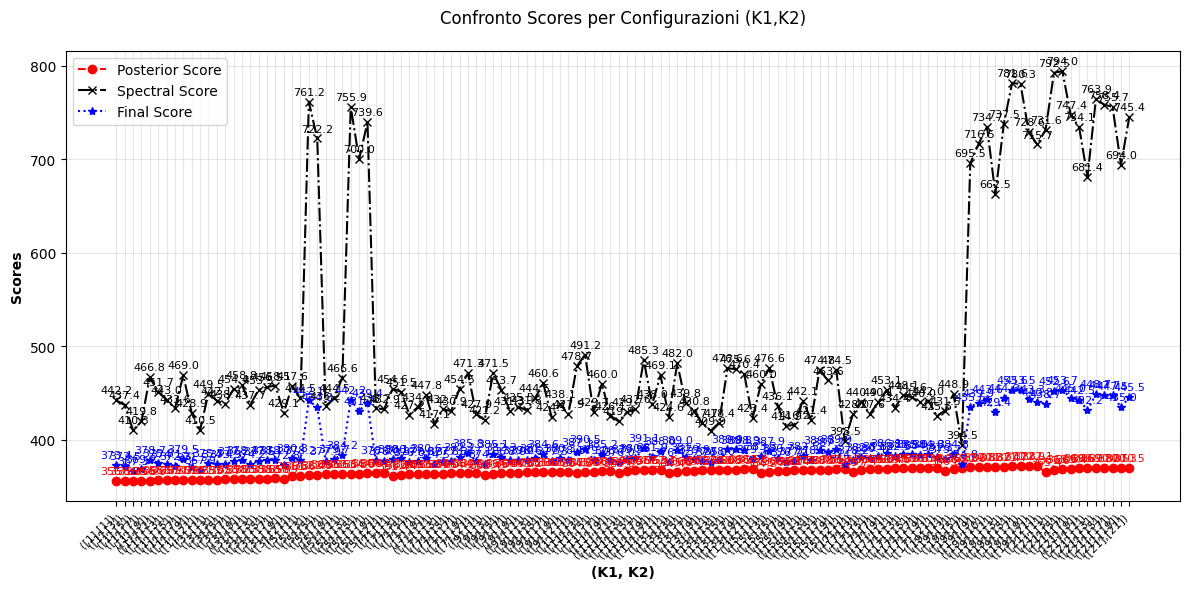

"\ndf_results = pd.DataFrame({\n    'K1': k1_values,\n    'K2': k2_values,\n    'PosteriorScore': posterior_vals,\n    'SpectralScore': spectral_vals,\n    'FinalScore': final_vals\n})\n# Salva su CSV\ndf_results.to_csv('results.csv', index=False)\n"

In [11]:
import ast
score_plot_ind = 0
# Leggi l'intero contenuto del file di testo
with open("results.txt", "r") as f:
    content = f.read()
# Suddividi in blocchi
blocks = [block for block in content.split('------------------------------') if block.strip()]
# Liste per accumulare i dati di TUTTE le iterazioni
k1_values = []
k2_values = []
posterior_vals = []
spectral_vals = []
final_vals = []
# Funzione per fare il parsing di un valore in modo sicuro
def safe_literal_eval(value):
    try:
        value = value.strip().lower()
        if value == "nan":
            return np.nan
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        print(f"Errore nel parsing: {value}")
        return None

# Parsing di tutti i blocchi
for block in blocks:
    k1, k2 = None, None
    posterior = spectral = final = None
    lines = [line.strip() for line in block.strip().splitlines() if line.strip()]
    for line in lines:
        if line.startswith("K1:"):
            k1 = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("K2:"):
            k2 = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Posterior"):
            posterior = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Spectral"):
            spectral = safe_literal_eval(line.split(":", 1)[1].strip())
        elif line.startswith("Final"):
            final = safe_literal_eval(line.split(":", 1)[1].strip())
    
    # Se tutti i valori sono validi, registra una riga
    if all(v is not None for v in [k1, k2, posterior, spectral, final]):
        k1_values.append(k1)
        k2_values.append(k2)
        # Se posterior/spectral/final sono array/list, fai la media
        posterior_vals.append(np.mean(posterior) if isinstance(posterior, (list, tuple, np.ndarray)) else posterior)
        spectral_vals.append(np.mean(spectral) if isinstance(spectral, (list, tuple, np.ndarray)) else spectral)
        final_vals.append(np.mean(final) if isinstance(final, (list, tuple, np.ndarray)) else final)

# Plot con coppie (K1,K2)
k_pairs = [f"({k1},{k2})" for k1, k2 in zip(k1_values, k2_values)]
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(k_pairs))
plt.plot(x_pos, posterior_vals, marker='o', color='red', label='Posterior Score', linestyle='--')
plt.plot(x_pos, spectral_vals, marker='x', color='black', label='Spectral Score', linestyle='-.')
plt.plot(x_pos, final_vals, marker='*', color='blue', label='Final Score', linestyle=':')
plt.xticks(x_pos, k_pairs, rotation=45, ha='right', fontsize=8)
plt.xlabel('(K1, K2)', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Confronto Scores per Configurazioni (K1,K2)', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
# Plot dei punti
for i, (p, s, f) in enumerate(zip(posterior_vals, spectral_vals, final_vals)):
    plt.annotate(f'{p:.1f}', (x_pos[i], p), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=8)
    plt.annotate(f'{s:.1f}', (x_pos[i], s), textcoords="offset points", xytext=(0,5), ha='center', color='black', fontsize=8)
    plt.annotate(f'{f:.1f}', (x_pos[i], f), textcoords="offset points", xytext=(0,5), ha='center', color='blue', fontsize=8)
plt.tight_layout()
plot_fname = get_unique_filename('Grafico','.png','./Cluster_Scores/')
plt.savefig(plot_fname)
plt.show()
# Scrittura su CSV dei risultati
'''
df_results = pd.DataFrame({
    'K1': k1_values,
    'K2': k2_values,
    'PosteriorScore': posterior_vals,
    'SpectralScore': spectral_vals,
    'FinalScore': final_vals
})
# Salva su CSV
df_results.to_csv('results.csv', index=False)
'''

# Grafico andamento clustering
### Fissato K1, il grafico indica l'andamento del final_score per il variare di K2

/var/folders/fl/bx5jfr0d24bcsm06cdps7zq00000gs/T/ipykernel_38139/1772797015.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10', len(k1_values)+2)


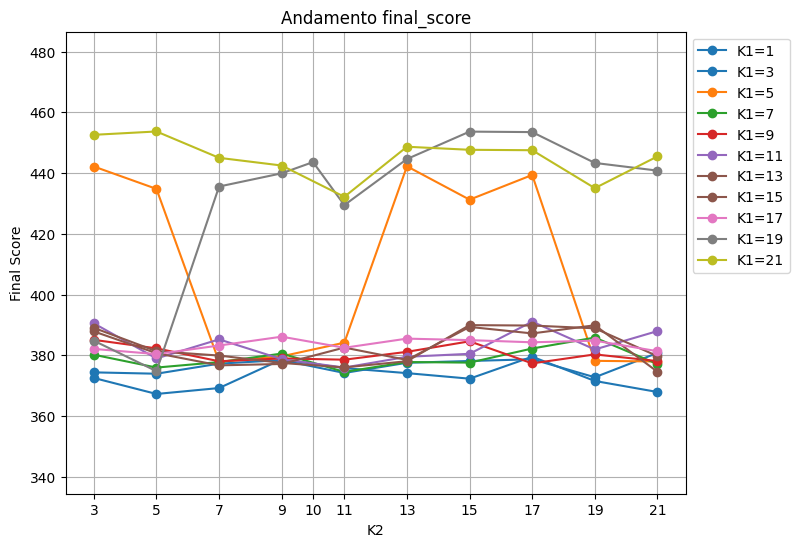

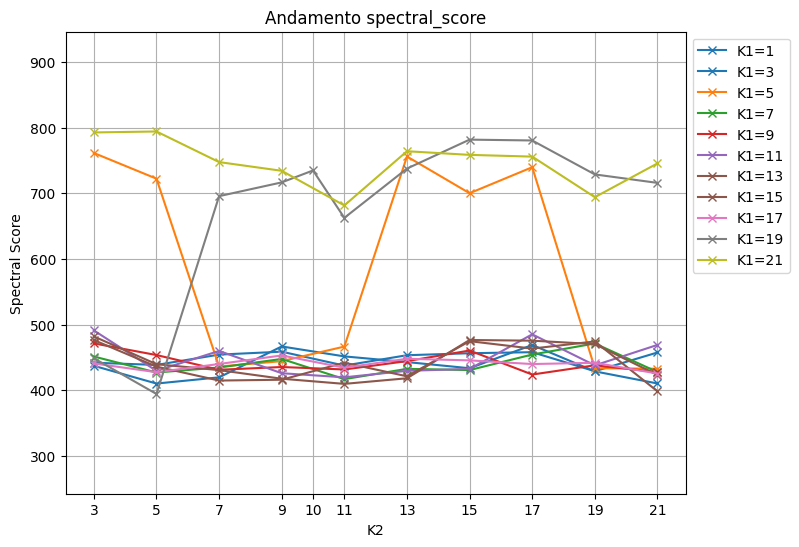

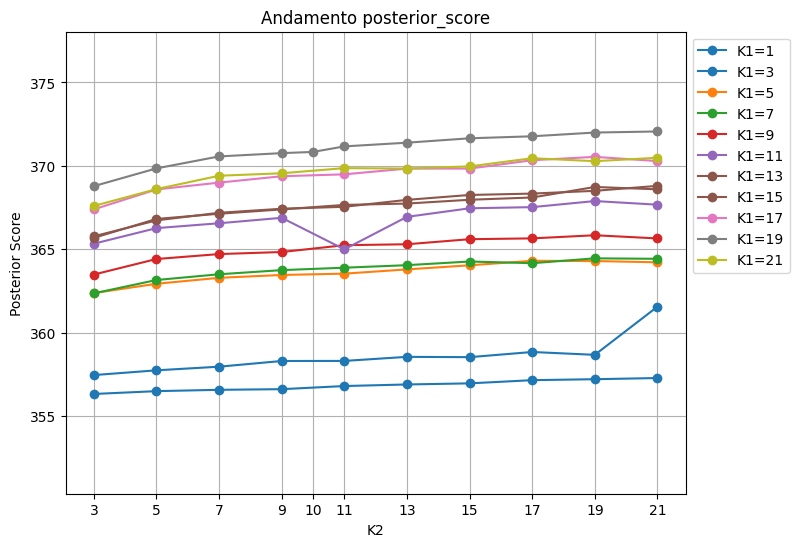

In [12]:
#------------|PLOT FINAL SCORE|------------#
df = pd.read_csv('results.csv')
# Rinomina delle colonne (se necessario)
df.columns = ['K1', 'K2', 'PosteriorScore', 'SpectralScore', 'FinalScore']
#-----Rimuovi le parentesi quadre e converti K1 e K2 in interi
df['K1'] = df['K1'].str.replace(r'[\[\]]', '', regex=True).astype(int)
df['K2'] = df['K2'].str.replace(r'[\[\]]', '', regex=True).astype(int)
#-----Filtraggio cluster a singolo sottocluster
# df = df[~((df['K2'] == 1) & (df['K1'] != 1))]  # esclude le righe dove K2 è 1 e K1 non è 1
df = df[df['K2'] != 1]  # esclude le righe dove K2 è 1
# Ordina il dataframe per K1 e K2
df = df.sort_values(by=['K1', 'K2'])
k1_values = sorted(df['K1'].unique())
unique_k2 = sorted(df['K2'].unique())
colormap = plt.cm.get_cmap('tab10', len(k1_values)+2)
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['FinalScore'], marker='o', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Final Score')
plt.title('Andamento final_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 10%
plt.ylim(y_min - margine, y_max + margine)
final_fname = get_unique_filename(f'Grafico_Final_{K1}-{K2}', '.png', directory='./Grafici_Clustering')
plt.savefig(final_fname)
plt.show()

#------------|PLOT SPECTRAL SCORE|------------#
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['SpectralScore'], marker='x', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Spectral Score')
plt.title('Andamento spectral_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 10%
plt.ylim(y_min - margine, y_max + margine)
spec_fname = get_unique_filename(f'Grafico_Spectral_{K1}-{K2}', '.png', directory='./Grafici_Clustering')
plt.savefig(spec_fname)
plt.show()

#------------|PLOT POSTERIOR SCORE|------------#
plt.figure(figsize=(8,6))
for i, k1 in enumerate(k1_values):
    subset = df[df['K1'] == k1].sort_values(by='K2')
    plt.plot(subset['K2'], subset['PosteriorScore'], marker='o', label=f'K1={k1}', color=colormap(i))
plt.xticks(unique_k2)
plt.xlabel('K2')
plt.ylabel('Posterior Score')
plt.title('Andamento posterior_score')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
y_min, y_max = plt.ylim()  # prendi i limiti correnti
margine = (y_max - y_min) * 0.3  # aggiunge un margine del 10%
plt.ylim(y_min - margine, y_max + margine)
post_fname = get_unique_filename(f'Grafico_Posterior_{K1}-{K2}', '.png', directory='./Grafici_Clustering')
plt.savefig(post_fname)
plt.show()

# Plotting delle distribuzioni
### Si utiliza 'corner' per il plot delle distribuzioni bayesiane a posteriori

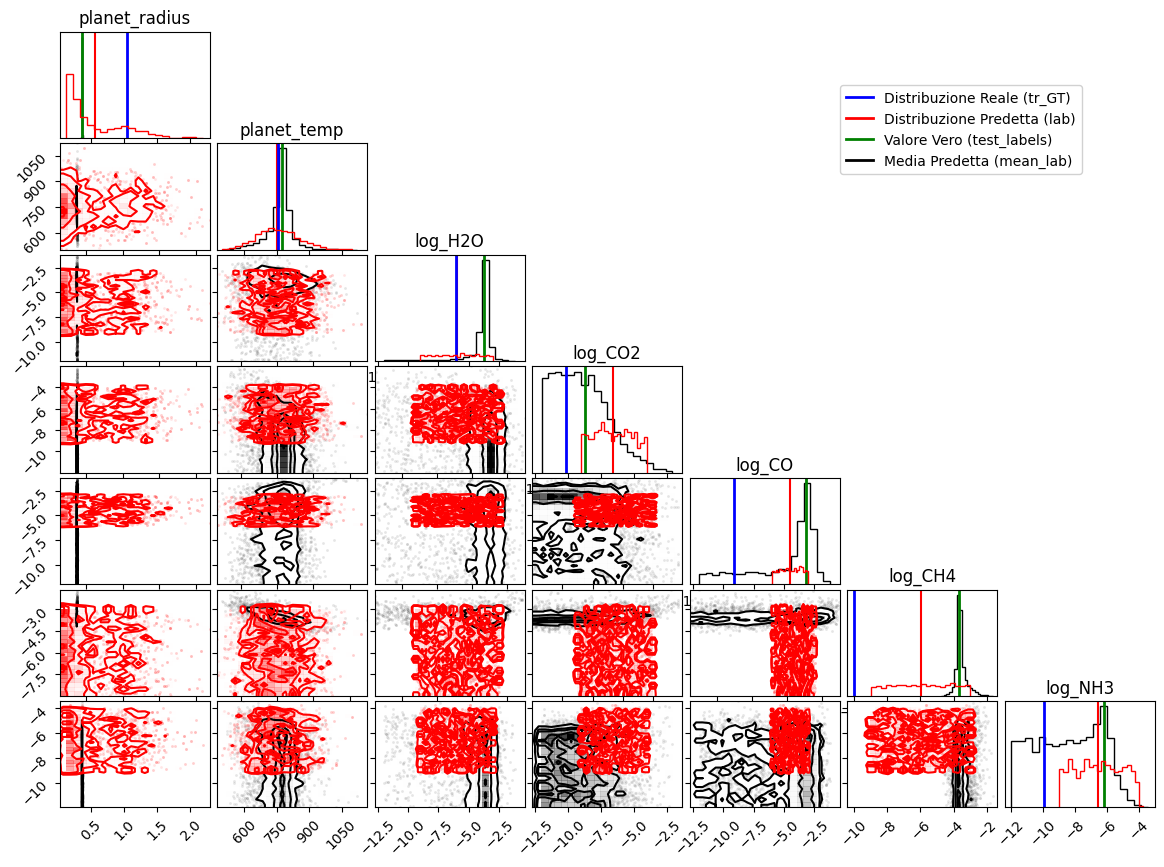

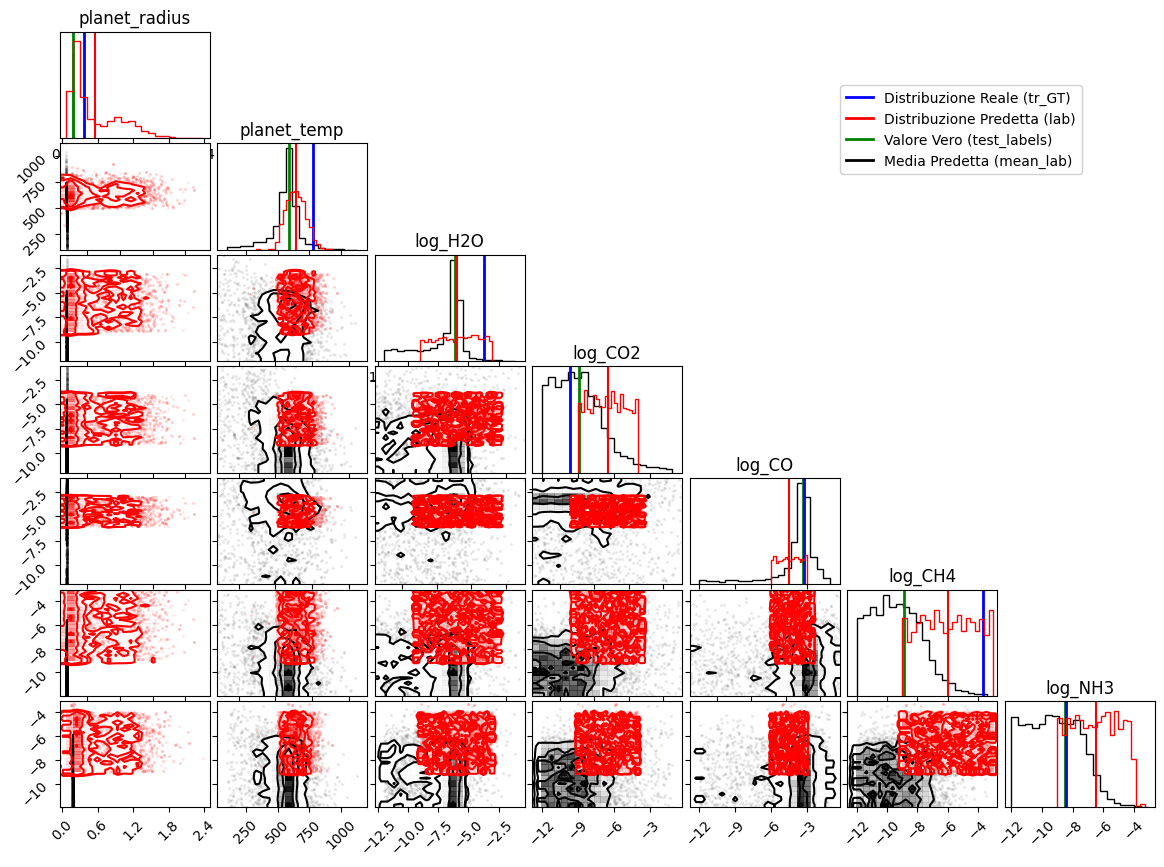

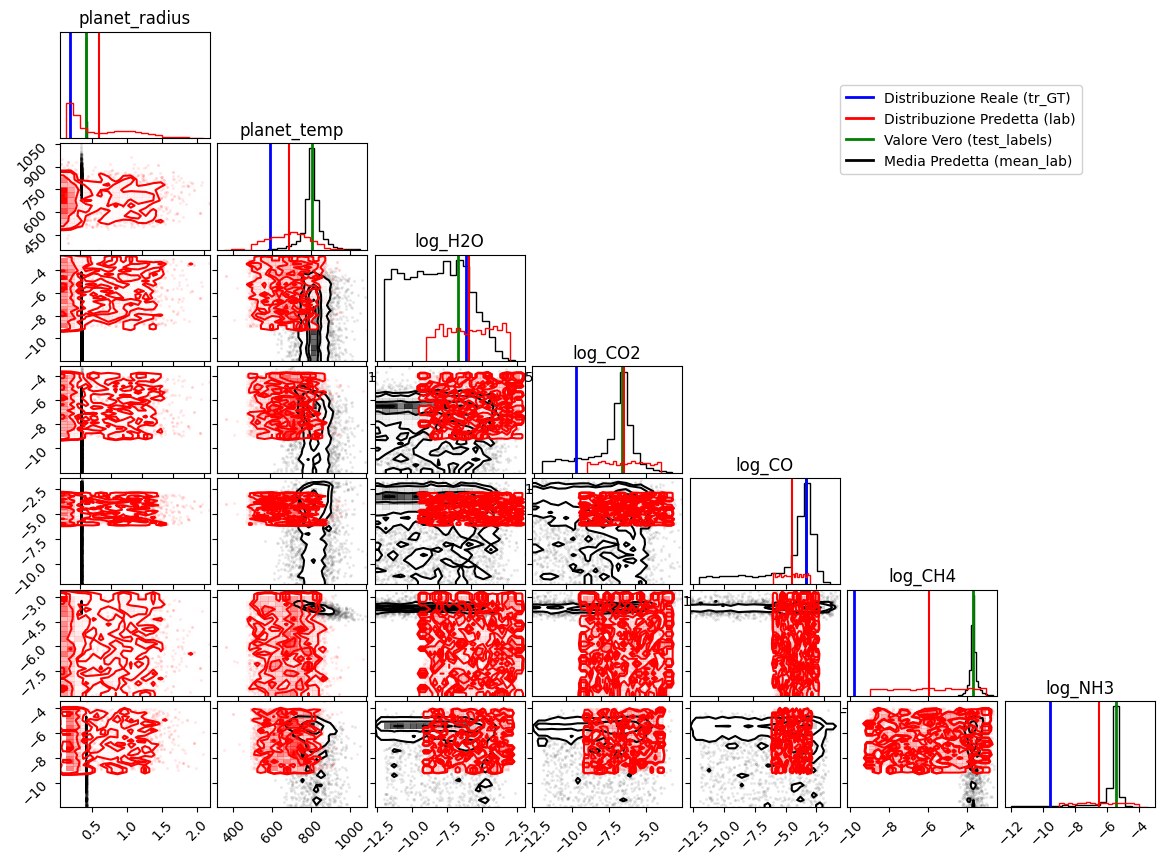

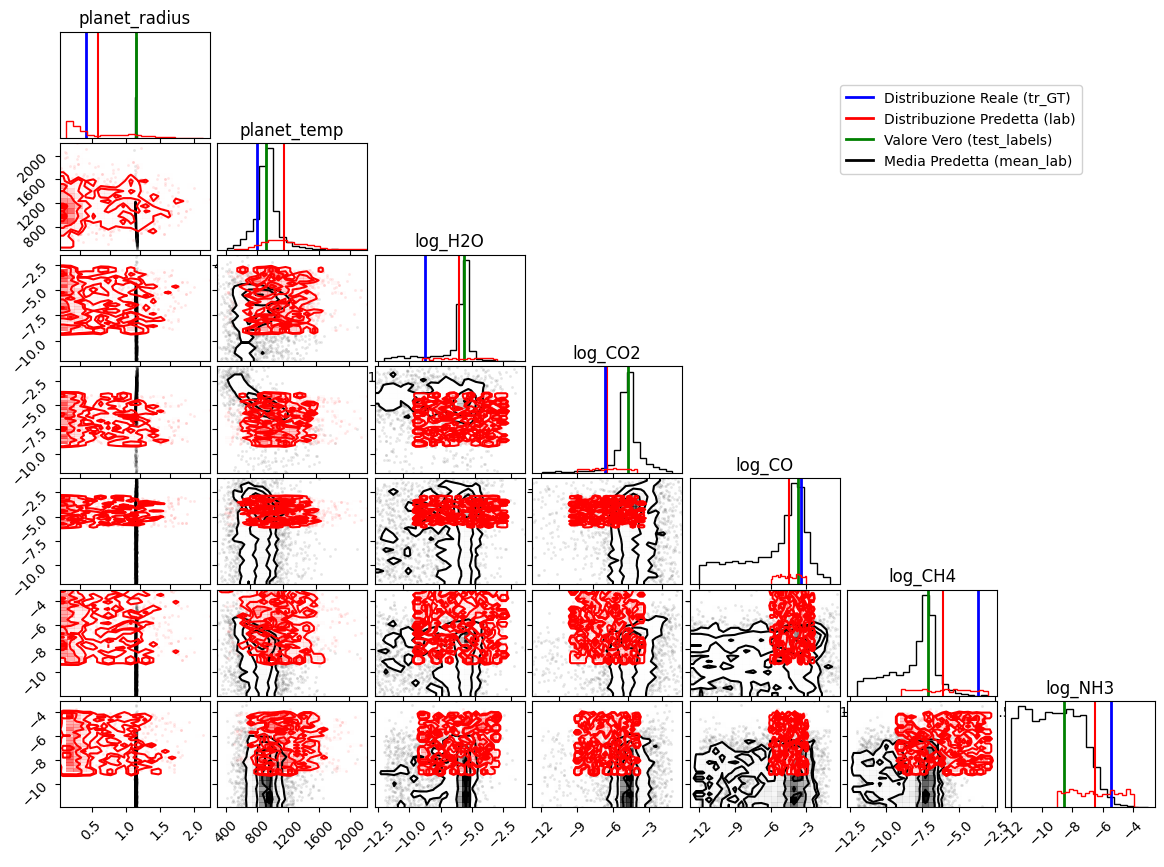

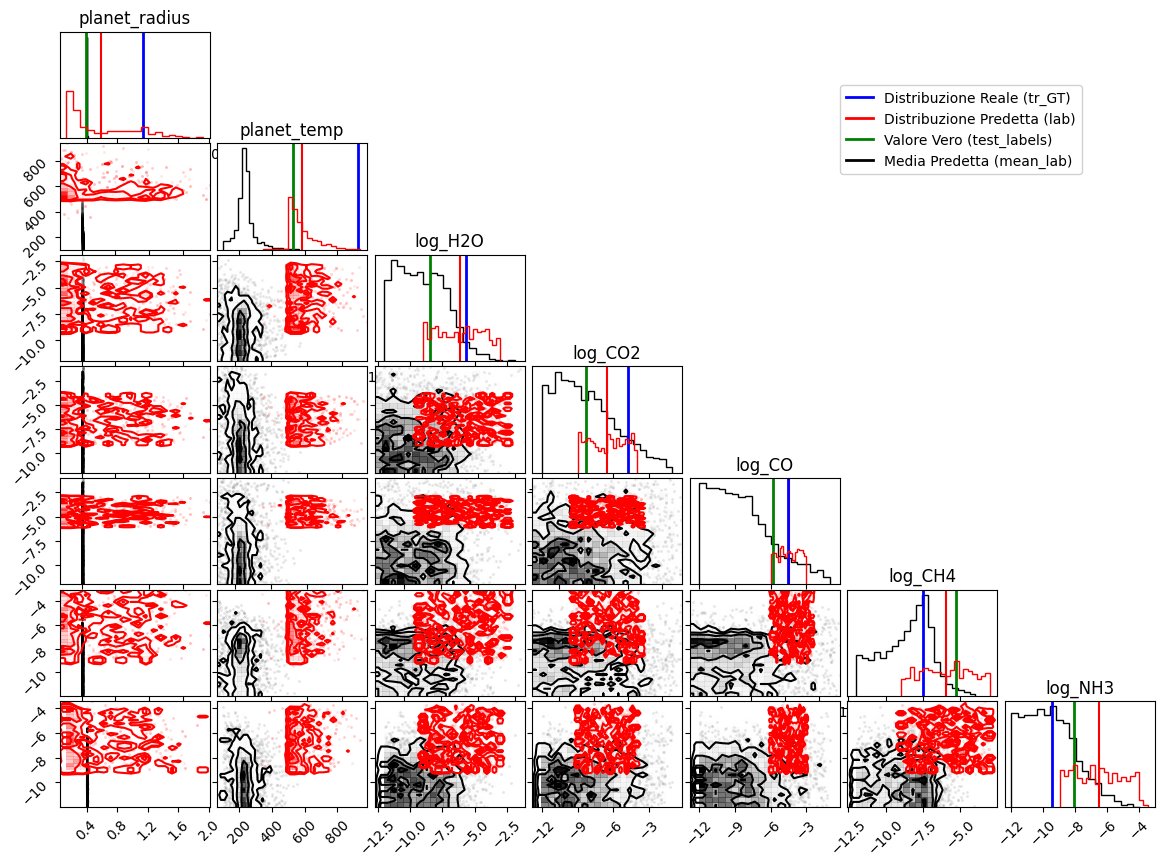

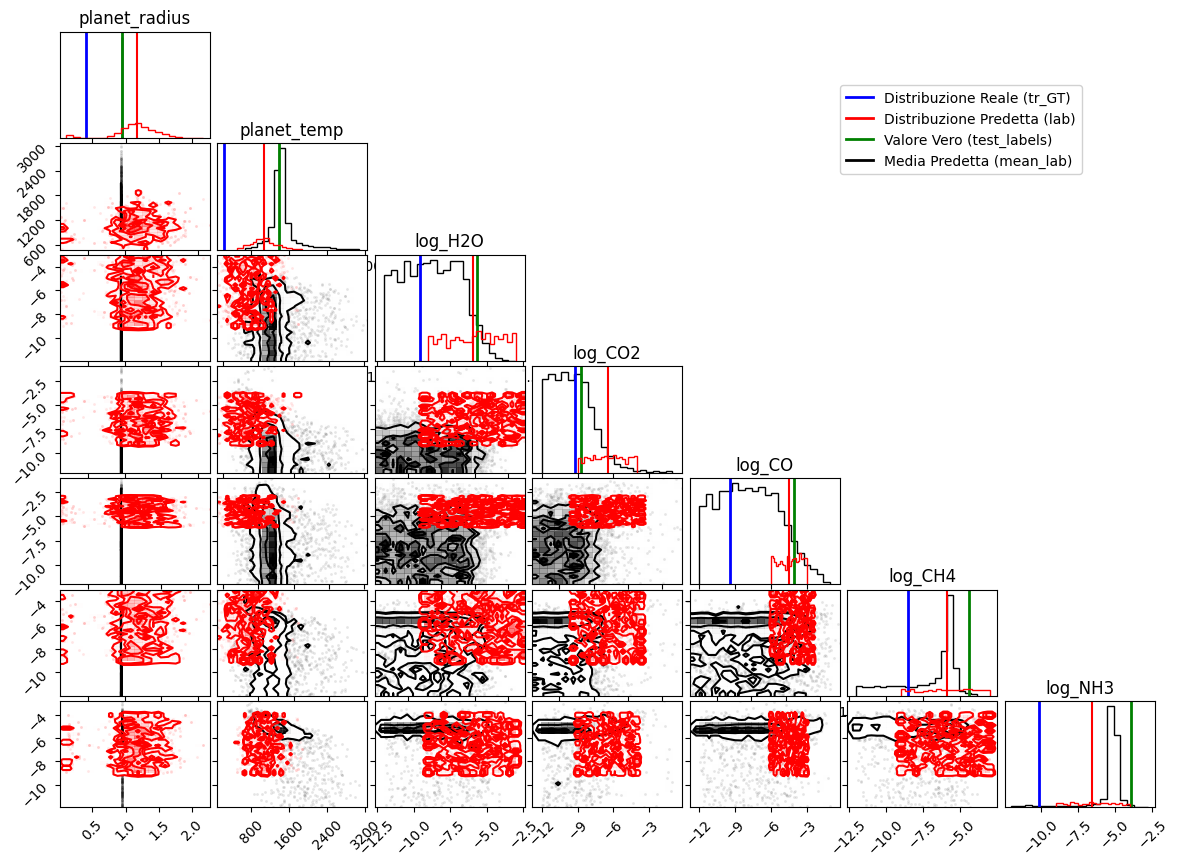

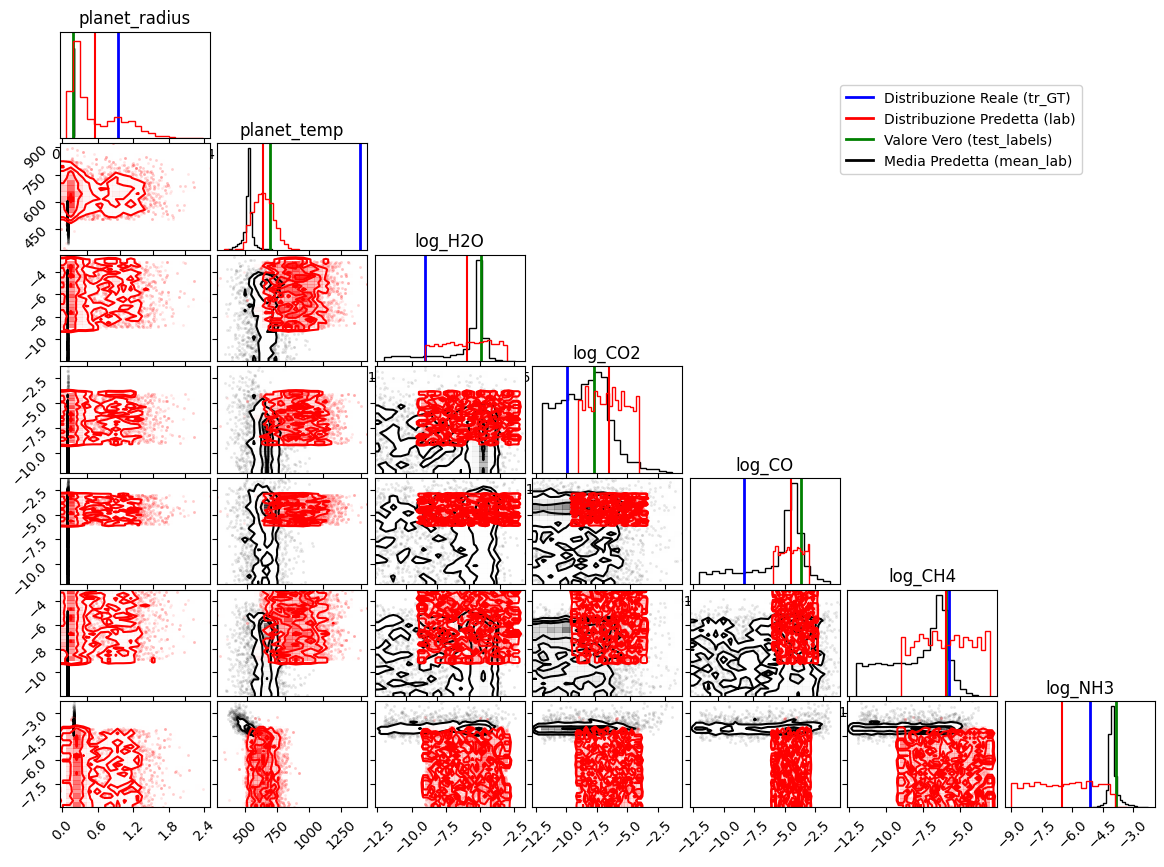

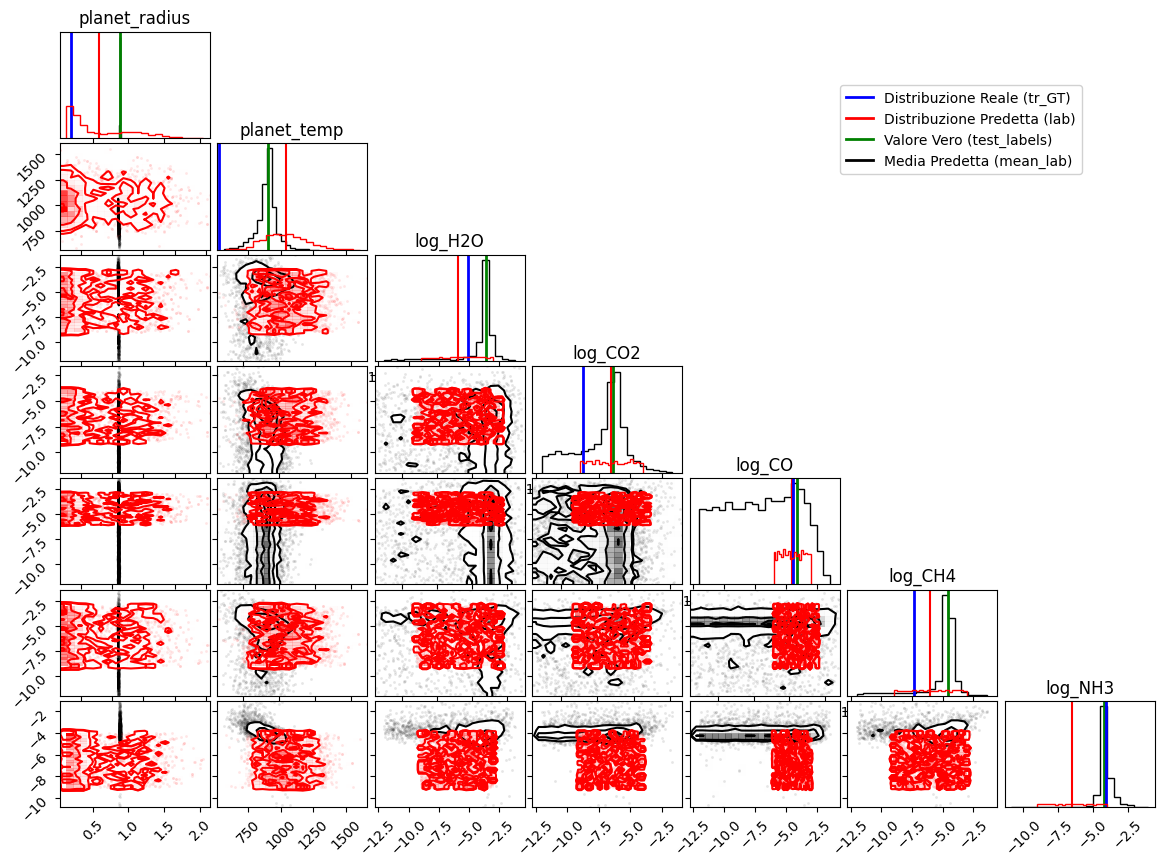

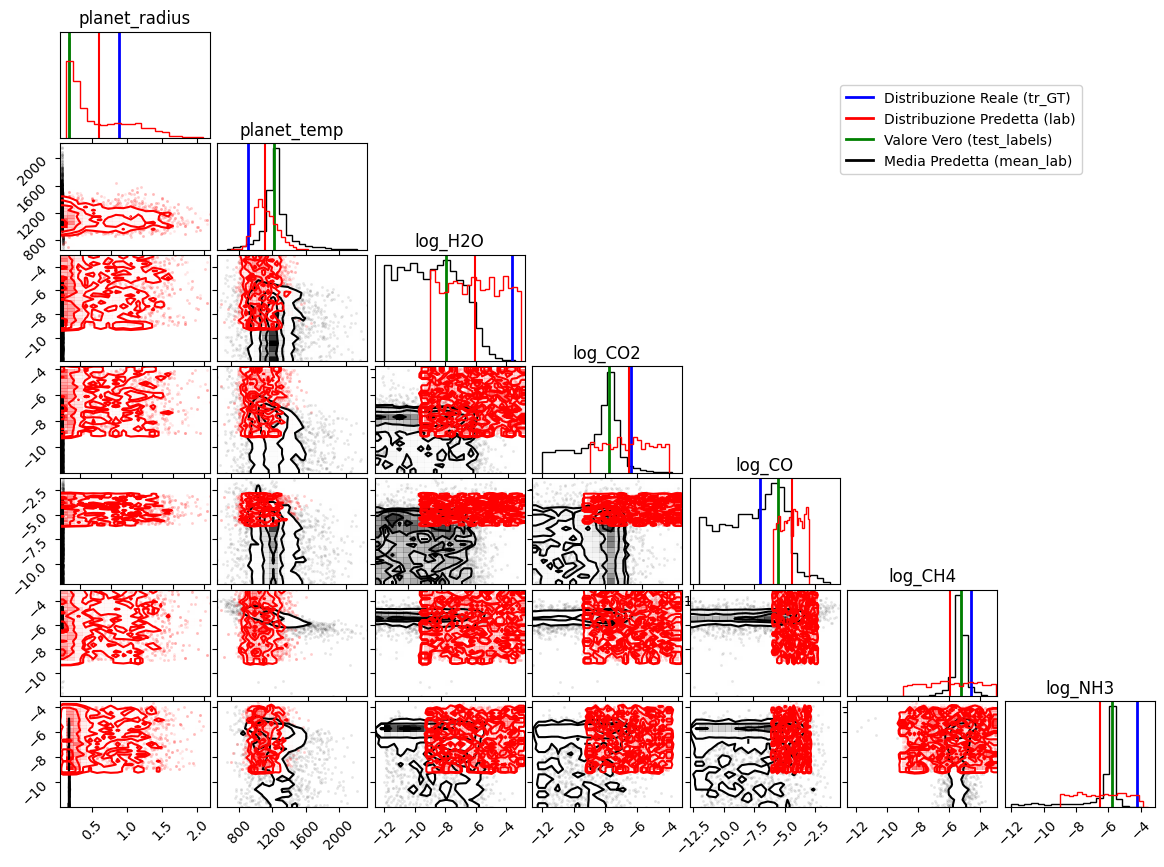

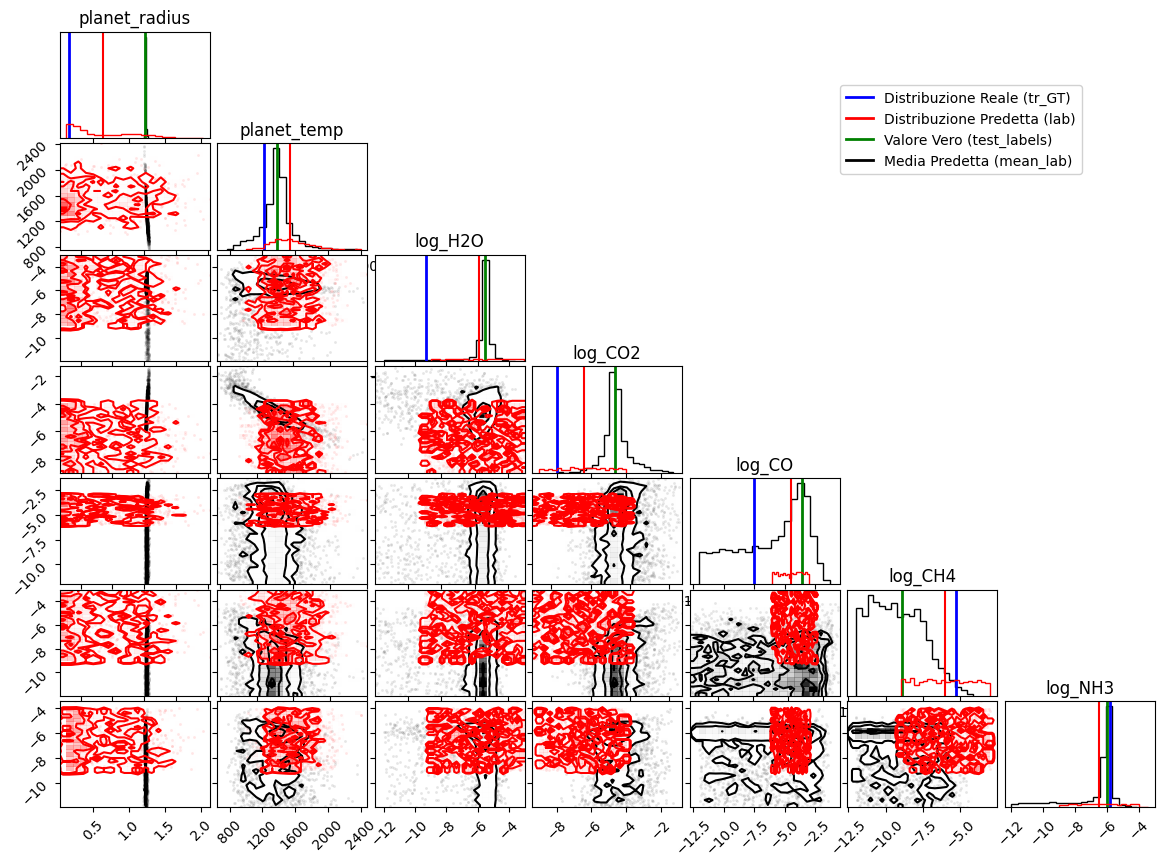

In [13]:
# Plottiamo le distribuzioni dei `plot_ind` spettri
for X in plot_ind:
	# Predizione sui dati ausiliari di test (1o livello)
	idx1 = gmm.predict(test_aux[X,:].reshape(1,-1))[0]
	km = GMM_i[idx1] # Selezione etichette
	labels_2 = Labels_i[idx1] 
	# Predizione sui dati spettrali di test (2o livello)
	idx2 = km.predict(test_spectra[X,:].reshape(1,-1))[0]
	idx_1 = np.where(labels_1 == idx1)[0] # Individuazione indici nel cluster
	idx_2 = np.where(labels_2 == idx2)[0] # Individuazione indici nel cluster
	lab = train_labels[idx_1[idx_2],:] 
	mean_lab = np.mean(lab,axis=0) # Media delle predizioni per il plot
	mean_GT = np.average(tr_GT,axis=0,weights=wh_GT) # Valore medio pesato dei dati reali
	# Lettura dati Ground Truth
	tr_GT = trace_GT[f'Planet_train{test_ind[X]+1}']['tracedata'][()]
	wh_GT = trace_GT[f'Planet_train{test_ind[X]+1}']['weights'][()]
	# Creazione della figura e plot dei dati reali
	figure = corner.corner(tr_GT,quiet=True) #,weights=wh_GT
	axes = np.array(figure.axes).reshape((tr_GT.shape[1], tr_GT.shape[1]))
	# Creazione della legenda
	legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Distribuzione Reale (tr_GT)'),
        Line2D([0], [0], color='red', lw=2, label='Distribuzione Predetta (lab)'),
        Line2D([0], [0], color='green', lw=2, label='Valore Vero (test_labels)'),
        Line2D([0], [0], color='black', lw=2, label='Media Predetta (mean_lab)')
    ]
	# Plot delle distribuzioni (reali)
	for i in range(tr_GT.shape[1]):
		ax = axes[i, i]
		ax.sharex(axes[tr_GT.shape[1]-1,i])
		ax.axvline(test_labels[X,i], color="g",lw=2)
		ax.axvline(mean_lab[i], color="r",lw=1.5)
		ax.axvline(mean_GT[i],color="blue",lw=2)
		#ax.axvspan(mean_lab[i] - std_lab[i], mean_lab[i] + std_lab[i], alpha=0.3, color='red')
		ax.relim()
		ax.autoscale()
		ax.set_title(labels_names[i])
	figure.legend(
        handles=legend_elements, 
        loc='upper right', 
        bbox_to_anchor=(0.92, 0.92),
        frameon=True,
        framealpha=0.9
    )
	figure.set_figheight(8.5)
	figure.set_figwidth(12)
	# Plot delle predizioni
	corner.corner(lab,fig=figure,quiet=True, color='red')
	figure.savefig('./GMM_plots/Planet_'+str(test_ind[X]+1)+'.png')
plt.show()

# Salvataggio risultati
### Salviamo i risultati mediante `to_competition_format()`, nel formato richiesto dalla Challenge 

In [14]:
# print(f'lab.shape = {lab.shape} - weights1.shape = {weights1.shape}')
out = to_competition_format(lab,weights1)